In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

###  Очистим текст, оставив только русские буквы и символы пробела

In [3]:
with open('tom_1.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower()
text = re.sub('[^а-яё ]','', text)

### Построим матрицу переходных вероятностей

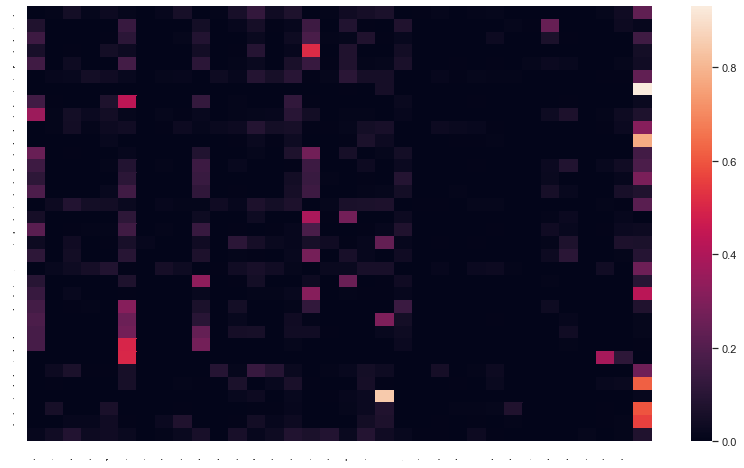

In [5]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN)}

probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

### Вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р

In [6]:
def get_letter_and_prob(prev_letter=None):
    if prev_letter is None:
        for s in list(RUSSIAN):
            yield s, 1.0/33
    else:
        p= POS[prev_letter]
        prob= probabilities[p]
        for s in list(RUSSIAN):
            sp = POS[s]
            yield s, prob[sp]

In [8]:
s='п'
e='р'
for s2, p2 in get_letter_and_prob(s):
    for s3, p3 in get_letter_and_prob(s2):
        for s4, p4 in get_letter_and_prob(s3):
            if s2==' ':
                pass
            elif s3==' ':
                pass
            elif s4==e:
                prob = p2*p3*p4
                if prob>0:
                    print(s+s2+s3+s4, prob)

паар 4.970246091922748e-07
пабр 4.2351648298520276e-05
павр 3.183941473027594e-05
пагр 5.6583312907222685e-05
падр 0.0001285018397060746
паер 6.605480349771346e-05
пазр 2.929450422176805e-05
паир 1.3476236497282564e-06
пайр 3.4373238806143546e-06
пакр 0.00018656022479414044
памр 3.7049577929562044e-06
панр 3.1024499211572896e-06
паор 1.984806147051644e-06
папр 0.00015480572195584354
парр 2.6611345344961707e-06
паср 1.707180611545666e-05
патр 0.00020804509670089067
паур 2.4952512621684063e-06
пафр 9.789336965478971e-05
пахр 7.702032156165372e-06
пачр 1.060507940379825e-06
пашр 2.912756300963162e-07
пащр 1.1826984894336846e-07
паэр 2.108167707034781e-08
паюр 7.238748748114168e-06
паяр 4.39402703254459e-06
пгар 1.467337371007378e-06
пгвр 3.47509175314893e-08
пгдр 2.5596737397416557e-06
пгер 2.1509310296537682e-06
пгзр 5.645938891771128e-10
пгир 3.63649987999575e-07
пгкр 2.2179146274923874e-07
пгмр 7.423458138201713e-10
пгнр 8.78010805497311e-09
пгор 2.1613019313286242e-05
пгпр 1.596869646

### сгенерируем слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов

In [9]:
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бремалы я


### Оценим ряд через HMM

1 -855.6201905961935
2 -767.9220576513217
3 -729.7130998068985
4 -698.3656038271708
5 -659.6273416753313
6 -662.2180727081831
7 -623.3203072519046
8 -602.2726720269773
9 -595.1309894641398
10 -575.3996946052305
11 -567.5106262368322
12 -562.9544292613432
13 -536.8183618366485


(10, 10)

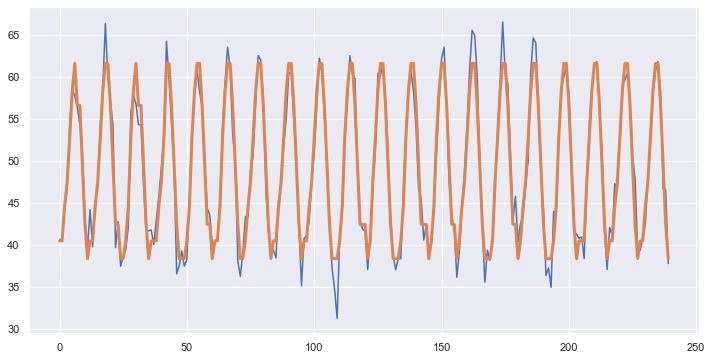

In [11]:
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM

series = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")["Deg"]

values = series.values.reshape(-1,1)

for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

model.transmat_.shape

### "построить" (через среднее каждой компоненты) наивный прогноз ряда

In [12]:
len(means)

240

In [13]:
len(values)

240

Разделяем на трейн и тест

In [43]:

train_size = int(len(means) * 0.67)
test_size = len(means) - train_size
train, test = means[0:train_size,:], means[train_size:len(means),:]
print(len(train), len(test))


160 80


Приведем данные в нужный формат

In [46]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [47]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


Зададим модель

In [48]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [49]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)









Epoch 1/200





 - 0s - loss: 855.3970
Epoch 2/200
 - 0s - loss: 584.6674
Epoch 3/200
 - 0s - loss: 360.0553
Epoch 4/200
 - 0s - loss: 198.8326
Epoch 5/200
 - 0s - loss: 100.3018
Epoch 6/200
 - 0s - loss: 50.5271
Epoch 7/200
 - 0s - loss: 30.2612
Epoch 8/200
 - 0s - loss: 23.4999
Epoch 9/200
 - 0s - loss: 21.5919
Epoch 10/200
 - 0s - loss: 21.1321
Epoch 11/200
 - 0s - loss: 21.0859
Epoch 12/200
 - 0s - loss: 21.1668
Epoch 13/200
 - 0s - loss: 21.1101
Epoch 14/200
 - 0s - loss: 21.0866
Epoch 15/200
 - 0s - loss: 21.1311
Epoch 16/200
 - 0s - loss: 21.1613
Epoch 17/200
 - 0s - loss: 21.0938
Epoch 18/200
 - 0s - loss: 21.1133
Epoch 19/200
 - 0s - loss: 21.1972
Epoch 20/200
 - 0s - loss: 21.1819
Epoch 21/200
 - 0s - loss: 21.1449
Epoch 22/200
 - 0s - loss: 21.1679
Epoch 23/200
 - 0s - loss: 21.2912
Epoch 24/200
 - 0s - loss: 21.0666
Epoch 25/200
 - 0s - loss: 21.1132
Epoch 26/200
 - 0s - loss: 21.0929
Epoch 27/200
 - 0s - loss: 21.1339
Epoch 28/200
 - 0s - loss: 21.1629
Epoch 29/200

Epoch 170/200
 - 0s - loss: 21.0952
Epoch 171/200
 - 0s - loss: 20.7364
Epoch 172/200
 - 0s - loss: 20.8333
Epoch 173/200
 - 0s - loss: 20.8009
Epoch 174/200
 - 0s - loss: 20.6689
Epoch 175/200
 - 0s - loss: 20.7100
Epoch 176/200
 - 0s - loss: 20.6951
Epoch 177/200
 - 0s - loss: 20.7497
Epoch 178/200
 - 0s - loss: 20.8279
Epoch 179/200
 - 0s - loss: 20.7867
Epoch 180/200
 - 0s - loss: 20.7832
Epoch 181/200
 - 0s - loss: 20.7298
Epoch 182/200
 - 0s - loss: 20.7381
Epoch 183/200
 - 0s - loss: 20.6925
Epoch 184/200
 - 0s - loss: 20.7143
Epoch 185/200
 - 0s - loss: 20.8245
Epoch 186/200
 - 0s - loss: 20.8303
Epoch 187/200
 - 0s - loss: 20.8110
Epoch 188/200
 - 0s - loss: 20.8224
Epoch 189/200
 - 0s - loss: 20.7326
Epoch 190/200
 - 0s - loss: 20.8115
Epoch 191/200
 - 0s - loss: 20.7534
Epoch 192/200
 - 0s - loss: 20.8404
Epoch 193/200
 - 0s - loss: 20.6875
Epoch 194/200
 - 0s - loss: 20.7409
Epoch 195/200
 - 0s - loss: 20.8612
Epoch 196/200
 - 0s - loss: 20.7678
Epoch 197/200
 - 0s - loss: 

Оценим качество

In [51]:
import math
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))


Train Score: 20.57 MSE (4.53 RMSE)
Test Score: 20.80 MSE (4.56 RMSE)


Построим 

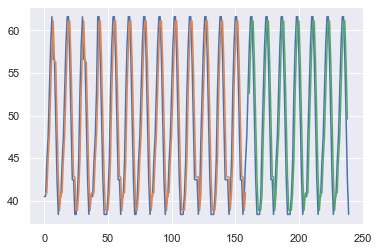

In [54]:

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictPlot = np.empty_like(means)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(means)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(means)-1, :] = testPredict

plt.plot(means)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
